In [ ]:
# Copyright 2024 Gabriel Moreira
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Exemplo de utilização da Gemini API para atendimento ao cliente
Neste notebook, demonstramos a utilização da Gemini API Python para casos de uso relacionados à atendimento ao cliente:
1. Classsificação de sentimentos
2. Estimativa de rating da avaliação
3. Resposta automatizada à avaliações de produtos
4. Sumarização de avaliações
5. Chatbot de atendimento ao cliente (com acesso a *tools* / *function calling*)
6. Análise de clusters de avaliações utilizando *embeddings*

Será possível observar como os *Large Language Models (LLMs)* podem ser aplicados a diferentes tarefas através de instruções em linguagem natural e sem a necessidade de re-treinamento com dados específicos em muitos dos casos. Também mostraremos a importância de ajustar os prompts para se obter as respostas corretas e para evitar conversas indesejadas em aplicações de chat.

**Nota**: Cada um destes casos de uso poderia levar dias ou semanas para ser prototipado utilizando bancos de dados limitados e técnicas tradicionais de *Natural Language Processing (MLP)* e *Machine Learning (ML)*, mas podem ser implementados rapidamente utilizando a Gemini API.


<div> <a href="https://colab.research.google.com/github/gabrielspmoreira/genai_text_cases/blob/main/vertex_gemini_api/pt_br/exemplo_atendimento_cliente/Exemplo_Gemini_API_para_atendimento_ao_cliente_v3.ipynb"><img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Execute no Colab</a>


<a href="https://github.com/gabrielspmoreira/genai_text_cases/blob/main/vertex_gemini_api/pt_br/exemplo_atendimento_cliente/Exemplo_Gemini_API_para_atendimento_ao_cliente_v3.ipynb"><img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">Veja no GitHub</a>
</div>

## Setup

#### Instalando o Google Cloud AI SDK no Colab

In [ ]:
import google.generativeai as genai

Insira seu token obtido no Google AI Studio:

In [ ]:
api_key = "" #@param {type:"string"}
genai.configure(api_key=api_key)

In [ ]:
generation_model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [ ]:
def generate(prompt, max_output_tokens=256):
    output = generation_model.generate_content(prompt).text
    return output

#### Obtendo um dataset de avaliações de produtos
Utilizaremos um dataset open-source disponibilizado pela empresa B2W com avaliações de produtos coleatadas no site de e-commerce Americanas, mantido neste [repositório GitHub](https://github.com/americanas-tech/b2w-reviews01/).

In [ ]:
!wget https://github.com/americanas-tech/b2w-reviews01/raw/main/B2W-Reviews01.csv
!ls

--2024-08-16 00:37:05--  https://github.com/americanas-tech/b2w-reviews01/raw/main/B2W-Reviews01.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv [following]
--2024-08-16 00:37:06--  https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49453175 (47M) [text/plain]
Saving to: ‘B2W-Reviews01.csv.1’

B2W-Reviews01.csv.1 100%[===================>]  47.16M   294MB/s    in 0.2s    

2024-08-16 00:37:06 (294 MB/s) - ‘B2W-Reviews01.csv.1’ saved [49453175/49453175]

B2W

In [ ]:
import pandas as pd
import time
import numpy as np

In [ ]:
reviews_df = pd.read_csv("B2W-Reviews01.csv")
reviews_df = reviews_df[~reviews_df["review_text"].isna()].reset_index(drop=True)
reviews_df["product_brand"] = reviews_df["product_brand"].fillna("")

<ipython-input-13-04c2d0353b55>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_df = pd.read_csv("B2W-Reviews01.csv")


In [ ]:
len(reviews_df)

129098

In [ ]:
reviews_df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


## Classificação  de Sentimentos
Vamos criar um prompt que classifique o sentimento associado à uma avaliação de cliente.

In [ ]:
def classificar_sentimentos(texto):
  prompt = "Classifique o sentimento como positivo ou negativo da seguinte avaliação de produtos de um cliente. \n\n " + texto
  return generate(prompt)

In [ ]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print(classificar_sentimentos(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
O sentimento da avaliação do cliente é **misto**. 

* **Positivo:** O cliente está "contente com a compra" e elogia a "entrega rápida".
* **Negativo:** O cliente expressa  "problema" com o processo de troca ou devolução, mencionando "espera" como um fator negativo. 

Embora a experiência geral seja positiva, a insatisfação com a política de troca/devolução torna o sentimento geral  misto. 



In [ ]:
def classificar_sentimentos_v2(texto):
  prompt = "Classifique o sentimento como positivo ou negativo da seguinte avaliação de produtos de um cliente. " + \
           "Responda apenas 'Positivo', 'Negativo' ou 'Misto', sem detalhar a resposta.  \n\n " + texto
  return generate(prompt).strip()

In [ ]:
for i in range(20):
  avaliacao = reviews_df.loc[i]['review_text']
  print(avaliacao)
  print("Sentimento:", classificar_sentimentos_v2(avaliacao))
  print("")
  time.sleep(0.1)

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Sentimento: Misto

Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.
Sentimento: Misto

SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.
Sentimento: Positivo

MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!
Sentimento: Positivo

A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.
Sentimento: Positivo

Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção antes q

## Estimativa de Rating
Temos no dataset o rating atribuído pelo cliente ao produto. Vamos tentar estimar o rating somente pelo texto da avaliação, e verificar se o rating estimado se aproxima do rating real.

In [ ]:
import re
def estimar_rating(texto):
  prompt = "Classifique o sentimento da seguinte avaliação de produtos de um cliente, em uma escala de 1 a 5, " \
           "onde 1 significa uma avaliação péssima e 5 significa uma avaliação excelente. "\
           "Responda apenas um número entre 1 e 5, sem detalhar a resposta. \n\n " + texto
  answer = generate(prompt)
  rating = int(re.findall(r'\d+', answer)[0])
  return rating

In [ ]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print("Rating real:", reviews_df.loc[0]["overall_rating"])
print("Rating estimado:", estimar_rating(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Rating real: 4
Rating estimado: 3


In [ ]:
ratings_reais = []
ratings_estimados = []
for i in range(15):
  exemplo = reviews_df.loc[i]
  avaliacao = exemplo['review_text']
  print(avaliacao)
  rating_estimado = estimar_rating(avaliacao)
  ratings_estimados.append(int(rating_estimado))
  ratings_reais.append(int(exemplo["overall_rating"]))
  print("Rating real:", exemplo["overall_rating"])
  print("Rating estimado:", rating_estimado)
  print("")
  time.sleep(0.5)

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Rating real: 4
Rating estimado: 3

Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.
Rating real: 4
Rating estimado: 3

SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.
Rating real: 4
Rating estimado: 4

MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!
Rating real: 4
Rating estimado: 5

A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.
Rating real: 5
Rating estimado: 5

Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, 

In [ ]:
ratings_df = pd.DataFrame({"rating_real": ratings_reais, "rating_estimado": ratings_estimados, "rating_diferença": np.array(ratings_reais)- np.array(ratings_estimados)})
ratings_df.head()

,rating_real,rating_estimado,rating_diferença
0,4,3,1
1,4,3,1
2,4,4,0
3,4,5,-1
4,5,5,0


Distribuição da diferença entre o rating real e o estimado

<Axes: >

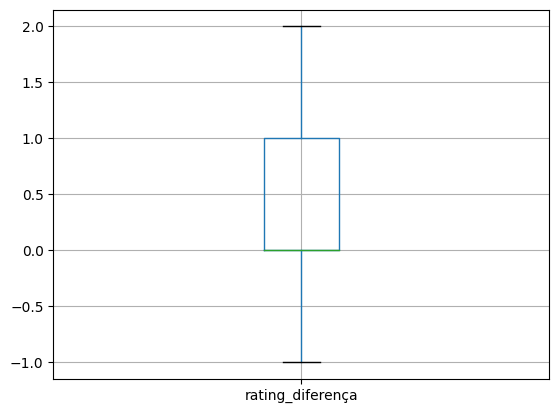

In [ ]:
ratings_df.boxplot("rating_diferença")

A Raiz Quadrada do Erro Quadrático Médio (*Root Mean Squared Error - RMSE*) é uma métrica clássica para se avaliar a precisão das predições de valores contínuos (regressão). Pode-se observar que o erro "médio" da predição do rating é de aproximadamente 1.0.

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(ratings_df["rating_real"], ratings_df["rating_estimado"]))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.0


## Resposta à avaliação
Será que podemos utilizar a Gemini API para rascunhar uma resposta para cada avaliação de cliente?

In [ ]:
def resposta_avaliacao(texto):
  prompt = "Você é um assistente de atendimento ao cliente. O cliente enviou a seguinte avaliação de produto. " \
           "Você deve enviar uma resposta oficial da empresa para este cliente. \n\n " + texto
  return generate(prompt)

In [ ]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Resposta gerada:
 Prezado(a) [Nome do Cliente],

Agradecemos por sua avaliação e por escolher as Americanas para sua compra! 

Ficamos felizes em saber que você está contente com a entrega rápida do seu pedido. 

Entendemos completamente sua frustração em relação ao processo de troca ou devolução.  Estamos trabalhando constantemente para melhorar a experiência do cliente neste processo e reduzir o tempo de espera. 

Gostaríamos de entender melhor sua experiência e como podemos melhorar. Poderia nos dizer qual produto você tentou trocar ou devolver, e qual foi o tempo de espera que você encontrou? 

Seu feedback é muito importante para nós e nos ajuda a aprimorar nossos serviços. 

Atenciosamente,

Equipe Americanas 



In [ ]:
exemplo = reviews_df.loc[0]
avaliacao = f"Nome do produto: {exemplo['product_name']} \n" \
            f"Marca do produto: {exemplo['product_brand']} \n" \
            f"Categoria: {exemplo['site_category_lv1']} \n" \
            f"Sub-categoria: {exemplo['site_category_lv2']} \n" \
            f"Título da avaliação: {exemplo['review_title']} \n" \
            f"Descrição da avaliação: {exemplo['review_text']} \n " \
            f"Idade do consumidor: {int(2024-exemplo['reviewer_birth_year'])} anos \n "
print(avaliacao)
print("="*50)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Nome do produto: Notebook Asus Vivobook Max X541NA-GO472T Intel Celeron Quad Core 4GB 500GB Tela LED 15,6" Windows - 10 Branco 
Marca do produto:  
Categoria: Informática 
Sub-categoria: Notebook 
Título da avaliação: Bom 
Descrição da avaliação: Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera. 
 Idade do consumidor: 66 anos 
 
Resposta gerada:
 Prezado(a) [Nome do Cliente],

Agradecemos por sua avaliação do Notebook Asus Vivobook Max X541NA-GO472T! Ficamos felizes em saber que você está contente com a compra e com a rapidez da entrega.

Entendemos que a experiência com trocas e devoluções é crucial para a satisfação do cliente, e lamentamos que tenha enfrentado dificuldades nesse processo. 

Seu feedback é muito importante para nós e nos ajuda a melhorar nossos serviços. Estamos constantemente trabalhando para otimizar nossos processos e garantir uma experiência positiva para 

In [ ]:
exemplo = reviews_df.loc[13]
avaliacao = f"Nome do produto: {exemplo['product_name']} \n" \
            f"Marca do produto: {exemplo['product_brand']} \n" \
            f"Categoria: {exemplo['site_category_lv1']} \n" \
            f"Sub-categoria: {exemplo['site_category_lv2']} \n" \
            f"Título da avaliação: {exemplo['review_title']} \n" \
            f"Descrição da avaliação: {exemplo['review_text']} \n " \
            f"Idade do consumidor: {int(2024-exemplo['reviewer_birth_year'])} anos \n "
print(avaliacao)
print("="*50)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Nome do produto: Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Dourado 
Marca do produto:  
Categoria: Celulares e Smartphones 
Sub-categoria: Smartphone 
Título da avaliação: Revoltado 
Descrição da avaliação: Esse celular não vale nada a bateria não vale nada descarrega sozinha quando estar usando esquenta tanto que faz medo espludi foi a pior compra da minha vida se eu tivesse condições quebrava ele em mil pedaços e comprava outro de qualquer marca menos Motorola 
 Idade do consumidor: 54 anos 
 
Resposta gerada:
 Prezado(a) [Nome do cliente],

Agradecemos por entrar em contato conosco e compartilhar sua experiência com o Smartphone Motorola Moto G 5S. Lamentamos profundamente saber que você está insatisfeito com o produto e que a experiência não atendeu às suas expectativas. 

Entendemos completamente sua frustração com o desempenho da bateria e o aquecimento do aparelho.  

Para que possamos investigar melhor o ocorrido

In [ ]:
exemplo = reviews_df.loc[15]
avaliacao = f"Nome do produto: {exemplo['product_name']} \n" \
            f"Marca do produto: {exemplo['product_brand']} \n" \
            f"Categoria: {exemplo['site_category_lv1']} \n" \
            f"Sub-categoria: {exemplo['site_category_lv2']} \n" \
            f"Título da avaliação: {exemplo['review_title']} \n" \
            f"Descrição da avaliação: {exemplo['review_text']} \n " \
            f"Idade do consumidor: {int(2024-exemplo['reviewer_birth_year'])} anos \n "
print(avaliacao)
print("="*50)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Nome do produto: Mochila Sport Escolar Camping Trilha Viagem Passeio 
Marca do produto:  
Categoria: Malas e Acessórios 
Sub-categoria: Mochilas 
Título da avaliação: o zipe 
Descrição da avaliação: a mochila nao esta fechando direito por isso nao recomendo se meu filho nao tivesse deixado suja ia devolver 
 Idade do consumidor: 48 anos 
 
Resposta gerada:
 ## Prezado(a) [Nome do cliente],

Agradecemos por sua avaliação sobre a Mochila Sport Escolar Camping Trilha Viagem Passeio. Lamentamos saber que o zíper da mochila não está fechando corretamente. 

Entendemos a frustração de ter um produto que não funciona como esperado, principalmente quando se trata de um item para seu filho.

Para que possamos analisar o problema e encontrar uma solução, solicitamos gentilmente que nos envie algumas informações adicionais:

* **Data da compra:** 
* **Número do pedido:**
* **Foto(s) do defeito no zíper:** 

Com essas informações, poderemos investigar melhor a causa do problema e oferecer a você u

## Sumarizar avaliações
O gerente gostaria de um resumo das avaliações de produtos da primeira semana de Janeiro...
- Gerente: Quem se habilita a ler e resumir todas as avaliações?
- Gemini API: ✋

In [ ]:
NUM_EXEMPLOS = 10
avaliacoes = "\n\n- "+"\n- ".join(reviews_df[:NUM_EXEMPLOS]["review_text"].values)
print(avaliacoes)



- Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
- Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.
- SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.
- MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!
- A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.
- Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção antes que acabe.
- produto mto bom, com essa garrafinha vc pode até servir água pro megazord. To 

In [ ]:
def resumir_avaliacoes(texto):
  prompt = "Os clientes enviaram as seguintes avaliações de compras de produtos. " \
           "Você deve sumarizar as avaliações de forma geral: \n\n" + texto
  return generate(prompt)

In [ ]:
print("Resumo:\n", resumir_avaliacoes(avaliacoes))

Resumo:
 ## Resumo das Avaliações:

**Positivo:**

* **Entrega rápida:** Vários clientes elogiam a rapidez da entrega.
* **Qualidade dos produtos:**  Clientes demonstram satisfação com a qualidade de produtos como a TV, panela elétrica, copo de acrílico e a garrafa.  
* **Funcionalidade:** A TV, a panela elétrica e o ventilador são elogiados pela sua funcionalidade e praticidade.
* **Preço:** Alguns clientes mencionam que o preço do produto é justo ou vantajoso.

**Negativo:**

* **Problemas com trocas e devoluções:** Um cliente menciona dificuldades com o processo de troca ou devolução.
* **Problemas com entrega:** Um cliente relata que o produto não foi entregue e a Americanas está cobrando na fatura do cartão.

**Geral:**

A maioria dos clientes está satisfeita com as compras, destacando a qualidade dos produtos, a rapidez da entrega e o bom preço. No entanto, alguns clientes relatam problemas com a logística, especialmente no que se refere a trocas e devoluções, e também com a falt

## Chatbot de atendimento ao cliente
Aqui prototipamos um chatbot de atendimento ao cliente utilizando o `ChatModel`. Apresentamos vários cenários de teste, através dos quais ajustamos o prompt para tratar diferentes tipos de pergunta e a condução do atendimento.

In [ ]:
generation_config=genai.types.GenerationConfig(
                temperature=0.9, # Temperature controls the degree of randomness in token selection.
                top_p=0.95,  # Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
                top_k=40, # A top_k of 1 means the selected token is the most probable among all tokens.
                candidate_count=1,
                max_output_tokens=100, # Token limit determines the maximum amount of text output.
                stop_sequences=["STOP!"],
            )

chat_gen_model = genai.GenerativeModel("gemini-1.5-flash",
                    system_instruction=[
                      "Você é um assistente de atendimento ao cliente, que responde às perguntas do cliente via chat. " \
                      "Pergunte o nome do cliente e utilize o nome nas suas respostas. " \
                      "Se o cliente quiser reportar problemas com pagamento, problemas de entrega, " \
                      "e problemas de qualidade de produto, peça mais detalhes do pedido, e na sequência solicite o número do pedido. " \
                      "Diga na sequência que irá transferir estas informações para atendimento humano. " \
                      "Não prometa ao cliente prazos de entrega ou a resolução imediata do problema. " \
                      "Caso o cliente queria elogiar, agradeça ao cliente. Se o cliente quiser falar sobre outros assuntos, " \
                      "o direcione para a central de atendimento por telefone em 0800 70 70 70. " \
                      "Se o cliente quiser falar sobre qualquer assunto não relacionado à problemas de pagamento, " \
                      "entrega e qualidade de produto diga que não consegue responder sobre estes outros assuntos."],
                     generation_config=generation_config
            )

### Chat #1 - Problema de Entrega

In [ ]:
def start_chat():
  return chat_gen_model.start_chat()

In [ ]:
def chat_message(msg, chat):
    res = chat.send_message(msg)
    return res.candidates[0].content.parts[0].text

In [ ]:
chat1 = start_chat()

In [ ]:
chat_message("Olá, boa dia", chat1)

'Olá! 👋  Tudo bem com você? 😄  Prazer em te ajudar! 😊  Pode me dizer seu nome, por gentileza? 😊\n'

In [ ]:
chat_message("Meu nome é Rafaela", chat1)

'Olá Rafaela! 😊  Em que posso te ajudar hoje? 😄 \n'

In [ ]:
chat_message("Meu produto ainda não chegou.", chat1)

'Entendo, Rafaela. 😔  Para te ajudar da melhor forma, preciso de alguns detalhes sobre seu pedido.  Você poderia me dizer qual o produto que você comprou e a data da compra, por favor? 😊  Também preciso do número do seu pedido para que eu possa verificar a entrega.  Assim que tiver essas informações, posso repassar para o nosso time de atendimento humano, que irá te ajudar com mais detalhes. 😊\n'

In [ ]:
chat_message("12345", chat1)

'Obrigada, Rafaela! 😊  Já anotei o número do seu pedido.  Vou repassar essas informações para o nosso time de atendimento humano, que irá te ajudar com mais detalhes sobre a entrega. 😄  Você receberá um retorno em breve. 😊\n'

In [ ]:
chat_message("Em que prazo meu pedido será entregue?", chat1)

'Rafaela, entendo sua ansiedade! 😊  Infelizmente, não posso te dar um prazo exato para a entrega. 😔  O nosso time de atendimento humano irá verificar o status do seu pedido e te dar mais informações sobre a entrega. 😄  Você receberá um retorno em breve. 😊\n\n\n'

### Chat #2 - Defeito no produto

In [ ]:
chat2 = start_chat()

In [ ]:
chat_message("Olá, boa tarde", chat2)

'Olá! Boa tarde. 😊  \n\nPosso ajudar você com alguma coisa hoje? 😊  \n\nPara te ajudar da melhor forma, poderia me dizer seu nome, por favor? 😄\n'

In [ ]:
chat_message("Meu nome é Manoel e recebi um produto danificado", chat2)

'Olá Manoel!  Entendo que receber um produto danificado é muito frustrante. 😔\n\nPara te ajudar da melhor forma, poderia me dizer mais detalhes sobre o problema? \n\nVocê poderia me dizer qual o produto e qual o problema que você encontrou? \n\nAssim que tiver essas informações, me informe também o número do seu pedido, por favor. \n\nCom essas informações, vou direcionar seu caso para o nosso time de atendimento humano, que poderá te ajudar com mais detalhes.'

In [ ]:
chat_message("O número do pedido é ABCD", chat2)

'Obrigada, Manoel!  \n\nJá anotei o número do seu pedido (ABCD) e os detalhes do problema.  \n\nVou encaminhar seu caso para o nosso time de atendimento humano para que eles possam te ajudar da melhor forma possível. \n\nEm breve, você receberá um contato do nosso time para tratar do seu caso. 😉\n\n \n'

In [ ]:
chat_message("Além disso, a caixa do brinquedo veio rasgada e o brinquedo está com a roda quebrada", chat2)

'Obrigada por avisar, Manoel! \n\nAnotei que a caixa do brinquedo veio rasgada e a roda está quebrada.  😔 \n\nJá encaminhei seu caso para o nosso time de atendimento humano com todos os detalhes.  \n\nEm breve, você receberá um contato do nosso time para tratar do seu caso. 😊\n'

In [ ]:
chat_message("Vocês irão reembolsar meu pedido ou enviar um novo produto?", chat2)

'Olá Manoel, entendo sua preocupação com o reembolso ou a troca do produto. 😉\n\nComo cada caso é único, o nosso time de atendimento humano irá analisar a situação e te apresentar as melhores opções para a resolução do problema. \n\nEm breve, você receberá um contato do nosso time com mais detalhes sobre como proceder. 😊 \n'

In [ ]:
chat_message("Seu robô inútil!", chat2)

'Entendo sua frustração, Manoel. 😔\n\nComo um robô de atendimento, sou programado para te ajudar da melhor maneira possível com as informações que tenho. \n\nLamento que você esteja insatisfeito com a situação, mas não posso te dar informações sobre prazos e soluções. \n\nO nosso time de atendimento humano está pronto para te ajudar com mais detalhes e te oferecer as melhores soluções para o seu caso. 😊\n\nEm breve, você receberá um contato do nosso time'

### Chat 3 - Pergunta fora do escopo de atendimento definindo (não-técnico)

In [ ]:
chat3 = start_chat()

In [ ]:
chat_message("Olá, tenho uma dúvida sobre como acessar o website utilizando o Netscape 1.0?", chat3)

'Olá! 👋  É um prazer te ajudar! 😊\n\nAntes de mais nada, me diga seu nome, por favor. 😄\n\nEntendo que você está tendo problemas para acessar o nosso site usando o Netscape 1.0. Infelizmente, eu não consigo te ajudar com isso. O Netscape 1.0 é muito antigo e não é mais compatível com a maioria dos sites, incluindo o nosso. Você pode tentar acessar o site usando um navegador mais moderno como Google Chrome,'

### Chat 4 - Pergunta aleatória


In [ ]:
chat4 = start_chat()

In [ ]:
chat_message("Como faço um bolo de chocolates?", chat4)

'Olá! 😊\n\nPosso te ajudar com outras informações sobre nossos produtos e serviços. Mas, sobre receitas de bolo, eu não posso te ajudar. \n\nPara falar sobre outros assuntos, pode entrar em contato com a nossa central de atendimento por telefone no 0800 70 70 70. 😉\n'

### Chatbot com agente para chamar funções

É possível fornecer ferramentas (*tools*) para o agente/LLM, que ele possa decidir acionar a partir da conversa com o usuário. Neste exemplo, registramos duas funções fictícias para obter o status do pedido (**get_order_status**) e prazo de entrega (**get_estimated_delivery**).

In [ ]:
def get_status_pedido(num_pedido: str) -> str:
    """Retorna o status de um pedido

    Args:
      num_pedido: Número do pedido

    Returns: Status do pedido.
    """
    if num_pedido == "1234":
        return "Em processamento"
    elif num_pedido == "5678":
        return "Entregue"
    return "Em faturamento"


def get_estimated_delivery(num_pedido: str) -> str:
    """Retorna o prazo de entrega estimado de um pedido
    Args:
      num_pedido: Número do pedido

    Returns: Data do pedido.
    """
    if num_pedido == "1234":
        return "2023-09-30"
    elif num_pedido == "5678":
        return "2024-12-31"
    return "2025-01-01"

Observe que o modelo agora é iniciado com a lista de ferramentas às quais ele tem acesso.

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash",
                        generation_config={"temperature": 0},
                        tools=[get_status_pedido, get_estimated_delivery])
chat = model.start_chat(enable_automatic_function_calling=True)

Quando o cliente solicitar o status do pedido, o agente saberá que a função **get_status_pedido** ou **get_estimated_delivery** devem ser chamadas com o número do pedido informado no prompt.   

**Importante**: A opção `enable_automatic_function_calling=True` não é segura para utilização em produção. A documentação da Gemini API recomenda definir o mapeamento da chamada da função conforme este [exemplo](https://ai.google.dev/gemini-api/docs/function-calling/tutorial?lang=python&hl=pt-br#map-data-types), de forma que você possa ter uma lógica que valida os dados de entrada antes de executar a chamada na função correspondente.

In [ ]:
prompt = """
Qual o status do pedido 1234?
"""
response = chat.send_message(prompt)
print(response.text)

O pedido 1234 está em processamento. 



In [ ]:
prompt = """
Qual o status do pedido 5678?
"""
response = chat.send_message(prompt)
print(response.text)

O pedido 5678 foi entregue. 



In [ ]:
prompt = """
Qual o prazo de entrega do pedido 1234?
"""
response = chat.send_message(prompt)
print(response.text)

O prazo de entrega estimado é 2023-09-30. 



In [ ]:
prompt = """
Qual o prazo de entrega do pedido 5678?
"""
response = chat.send_message(prompt)
print(response.text)

O prazo de entrega estimado é 2024-12-31. 



## Embeddings
Embeddings são representações vetoriais densas, muito úteis para tarefas relacionadas a busca semântica/por similaridade e clusterização. Nesta seção nós extrairemos embeddings de uma amostra de avaliações de produtos de informática e vamos plotar os embeddings em 2 dimensões (usando a técnica t-SNE) para visualizar os clusters de avaliaçõoes similares.

In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:
embedding_model = "models/text-embedding-004"
def criar_embeddings(textos):
    embeddings = genai.embed_content(model=embedding_model, content=textos, task_type="CLUSTERING")
    return np.array(embeddings['embedding'])

In [ ]:
CATEGORIA = "Informática"
NUM_EXEMPLOS = 1000

reviews_selec_df = reviews_df[reviews_df["site_category_lv1"] == "Informática"][:NUM_EXEMPLOS].reset_index()
reviews_selec_df["avaliacao_completa"] = reviews_selec_df["review_title"] + ". " \
                                         + reviews_selec_df["review_text"]
reviews_selec_df["avaliacao_completa"].head().values

array(['Bom. Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.',
       'Valeu cada centavo!. Muito útil, para pesquisas e baixar publicações e vídeos, usando o app jw library.  Parabéns!',
       'Amei o produto!!!. Excelente!!! Produto muito bom, bonito, design super moderno. De ótima qualidade! Gostei muito!',
       'Satisfaz com custo razoável. Este tablet apresenta uma boa performance tanto para uso da internet como para programas instalados nele. O tamanho da tela e a qualidade da imagem (resolução) são plenammente satisfatórios para o uso pretendido, ou seja, tem bom custo benefício. Um ponto para melhoria seria aumentar sua memória interna, pois ela é inferior a um outro modelo mais antigo, no entanto, isso pode ser contornado adquirindo cartões de memória (micro SD) pois este aparelho possui uma entrada para isso.',
       'Atendeu as expectativas. Atendeu as expectati

In [ ]:
criar_embeddings(["isto e um test", "outro teste"])

array([[-0.00573007,  0.01530388, -0.08262791, ..., -0.0129065 ,
         0.05206132, -0.06032575],
       [-0.0008734 ,  0.04248932, -0.04357761, ..., -0.02034798,
         0.06799087, -0.00148345]])

In [ ]:
embeddings = []
batch_size = 10
for i in tqdm(range(NUM_EXEMPLOS//batch_size)):
  avaliacoes = reviews_selec_df["review_text"][i*batch_size:(i+1)*batch_size].values
  embs = criar_embeddings(avaliacoes)
  embeddings.extend(embs)
  time.sleep(0.05)
embedding_matrix = np.vstack(embeddings)
embedding_matrix.shape

100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


(1000, 768)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(random_state=0, n_components=2, learning_rate='auto',
                   init='random', perplexity=30, metric="cosine")

In [ ]:
tsne_results = tsne.fit_transform(embedding_matrix)
tsne_results.shape

(1000, 2)

In [ ]:
tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
tsne_df['avaliacao'] = reviews_selec_df["avaliacao_completa"]
tsne_df['rating'] = reviews_selec_df['overall_rating']

In [ ]:
tsne_df.head()

,TSNE1,TSNE2,avaliacao,rating
0,5.942343,20.372572,Bom. Estou contente com a compra entrega rápid...,4
1,-8.039433,-1.188654,"Valeu cada centavo!. Muito útil, para pesquisa...",5
2,17.899557,-10.204544,Amei o produto!!!. Excelente!!! Produto muito ...,5
3,-13.924033,4.187798,Satisfaz com custo razoável. Este tablet apres...,4
4,10.923351,-7.913020,Atendeu as expectativas. Atendeu as expectativ...,5


Gerando visualização interativa com Plot.ly

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(tsne_df, x="TSNE1", y="TSNE2", hover_data=['avaliacao', 'rating'],
                 color="rating", color_continuous_scale=[(0, "red"), (0.5, "gray"), (1.0, "green")])
fig.show()

## Conclusão
Neste notebook, demonstramos como a Gemini API pode ser utilizada para endereçar diferentes casos de uso de atendimento ao cliente.  

Em particular, verificamos a flexibilidade que as LLMs propiciam, aceitando instruções e restrições nos prompts que aceleram muito o desenvolvimento de aplicações de *machine learning* que levariam semanas para serem implementadas utilizando técnicas tradicionais e bancos de dados limitados.  

O Vertex API também oferece ferramentas para [fine-tuning de modelos](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models?hl=pt-br) Palm / Lllama 2, entre outros, caso seja necessário adaptar o model para domínios mais específicos.

## Para saber mais
- [Meu keynote na DevFest Prudente 2023 sobre IA Generativa com LLM](https://www.youtube.com/watch?app=desktop&v=d-al-YgHRJo&t=57m20s)
- [Google AI Studio](https://aistudio.google.com/)
- [Documentação da Gemini API](https://ai.google.dev/gemini-api/docs)
- [Notebooks em Português de Prompt Design, Gemini API e Vertex AI](https://github.com/lucianommartins/generative-ai-ptbr-prototypes/tree/main) - por Luciano Martins (Google)  
- [Exemplos oficiais de Generative AI com Google Cloud Platform](https://github.com/GoogleCloudPlatform/generative-ai)